## 1. PyCBC Tutorial: Accessing the Catalog of Binary Mergers and LIGO/Virgo Open Data

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how to get information about the catalog of binary mergers programmatically, and also how to read in detector strain data around each event, or from the full open data set released for LIGO's first observing run.

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

#### Getting the software environment setup

PyCBC is installable through pip, but also relies on portions of the [LALSuite]() c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [1]:
!pip install lal pycbc

### 1.1 Catalog of Binary Mergers

PyCBC provides an [API](http://pycbc.org/pycbc/latest/html/catalog.html) to look at the catalog of binary mergers a few examples below. Some key information, such as the 'chirp' mass of a binary merge can be retrieved.

#### What binary mergers are in the catalog? ####

In [2]:
from pycbc import catalog

### List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)


LVT151012
GW170608
GW150914
GW170814
GW170817
GW170104
GW151226


#### How can I get parameters? ####

One can also retrieve some of the basic parameters of each source
from the catalog directly as follows. Note that all parameters are given
in the *source* frame. This means that they include the effect of redshift.

In [3]:
# Either from the catalog as a whole
mchirp = catalog.Catalog().median1d('mchirp')
print(mchirp)

# or from a specific merger
mchirp_gw170817 = catalog.Merger("GW170817").median1d('mchirp')
print('GW170817: {}'.format(mchirp_gw170817))

[ 15.1     7.9    28.1    24.1     1.188  21.1     8.9  ]
GW170817: 1.188


#### Transform Mass Parameters into the Detector Frame

By default the above interface returns parameters in the *source* frame. Due to cosmological redshift, gravitational-waves are stretched as they travel. This causes the observed waveform to be different in the detector frame. This corresponds to an observed change in the mass parameters (for example). However, the relationship is fairly straighforward.

In [4]:
m = catalog.Merger('GW150914')
source_mtotal = m.median1d('mtotal')
redshift = m.median1d('redshift')
det_mtotal = source_mtotal * (1 + redshift)

print('Total Mass of GW150914')
print('Source Frame: {} Solar Masses'.format(source_mtotal))
print('Detector Frame: {} Solar Masses'.format(det_mtotal))

Total Mass of GW150914
Source Frame: 65.3 Solar Masses
Detector Frame: 71.177 Solar Masses


### 1.2 Accessing LIGO/Virgo data

In this section, we will look into how to read detector data from the LIGO and Virgo instruments using the PyCBC API. It is possible to both get data around specific events, and also from the full data sets which have been released which cover the S5/S6/O1 LIGO observing runs. Data will be returned as [pycbc TimeSeries objects.](http://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries)

#### Getting Data Around  Specific Binary Merger in the Catalog

One can directly retrieve data around a specific even. Typically this data is centered on the event, though restrictions may apply which have not allowed this. This method by default gets the smallest version of the dataset. If additional data or specific versions are required, please see the following two additional ways to access data.

Duration: 32.0s Start: 1126259446 End: 1126259478


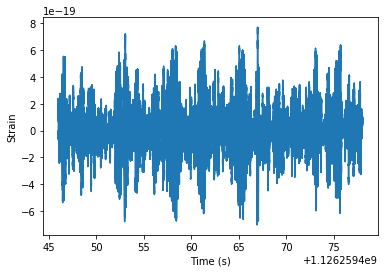

In [5]:
%matplotlib inline

import pylab

m = catalog.Merger("GW150914")

# Get the time series data around GW150914 from Hanford
# 'ts_han' is a pycbc.types.TimeSeries object which contains
# gravitational-wave strain in this instance and has metadata
# such as the start time, and sample rate.
ts_han = m.strain('H1')

# And now livingston
ts_liv = m.strain('L1')

# We can see how much data was returned and its boundaries
# Note: All times are given in seconds since the GPS time epoch
print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

# We can directly plot the time series as follows
pylab.plot(ts_han.sample_times, ts_han)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

#### Getting Data from S5 / S6 / O1

In this section we show how to read data from the bulk data release by LIGO. This currently covers the periods of teh S5, S6, and O1 analyses.

In [6]:
from pycbc.frame import query_and_read_frame

# Retrieve the approximate time of the merger
m = catalog.Merger("GW150914")
start = m.time - 32
end = m.time + 32

# Get 64 seconds of data roughly around GW150914
# The start / end time may be any in the publicly available data sets.
ts = query_and_read_frame('LOSC', 'H1:LOSC-STRAIN', start, end)

# If we wanted to retreive data from the Livingston detector
# we'd use the following command instead
# ts = query_and_read_frame('LOSC', 'L1:LOSC-STRAIN', start, end)

print("Returned {}s of data at {}Hz".format(ts.duration, ts.sample_rate))

Returned 64.0s of data at 4096Hz


#### Directly Reading gravitational-wave Frame Files

If you store LIGO data on your own computer then you can directly read in the data as follows.

In [7]:
# We'll first download some data for this demonstration
!curl -O -J https://losc.ligo.org/s/events/LVT151012/H-H1_LOSC_4_V2-1128678884-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1004k  100 1004k    0     0   502k      0  0:00:02  0:00:02 --:--:--  428k0:01  0:00:30 24619


In [8]:
from pycbc.frame import read_frame

# Read the data directly from the Gravitational-Wave Frame (GWF) file.
file_name = "H-H1_LOSC_4_V2-1128678884-32.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:LOSC-STRAIN"

start = 1128678884
end = start + 32

ts = read_frame(file_name, channel_name, start, end)